In [1]:
import numpy as np
import pandas as pd 
import pickle

from scipy import sparse
from scipy import stats
import scipy
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix, hstack
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import splrep

from sklearn import tree
from sklearn.tree import _tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from sklearn.grid_search import GridSearchCV 
from sklearn import preprocessing
from statsmodels.nonparametric.api import KernelReg
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import DescrStatsW

import matplotlib.pyplot as plt
import matplotlib


import seaborn as sns
import graphviz as grviz

from pygam import LinearGAM , s , f

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance
from xgboost import plot_tree

from patsy import dmatrix

import shap

root = 'C:\\Users\\yossi\\jupyter notebook\\XGboost\\xgboostlab\\'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


from IPython.display import display
pd.set_option('use_inf_as_na', True)

ImportError: cannot import name 'datetools'

In [2]:

dflearning = pd.read_csv(root + 'dflearning.csv')
dflearning = dflearning.sample(frac=1)
dflearning = dflearning.replace(np.Inf, np.nan)
# for those who want to use features from household data (you have to left join them to prat data and also for scoring:
dflearningMB = pd.read_csv(root + 'dflearningMB.csv')

C:\Users\goldi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,53,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\goldi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
dflearning.head(100)

## Visual analysis of targets 20012 - 2016

## Mission 1: PREDICT LBOUR FORCE PARTICIPATION - LFP

In [ ]:
transition = pd.crosstab(index=dflearning["labour_force_participation"], 
                            columns=dflearning[ 'futereLFP'],
                             margins=True)
transition.style.format("{:,.0f}")

In [ ]:
transition.div(transition["All"],axis=0).style.format("{:.2%}")    

## Mission 2: Relative income rank change - Predict decile income group improvment at 2016

In [ ]:
transition = pd.crosstab(index=dflearning["incomeGroup"], 
                            columns=dflearning['futureIncomeGroup'],
                             margins=True)

transition.style.format("{:,.0f}")

In [ ]:
transition = pd.crosstab(index=dflearning["incomeGroup"], 
                            columns=dflearning['incomeGroupUp'],
                             margins=True)

transition.style.format("{:,.0f}")

In [ ]:
transition.div(transition["All"],axis=0).style.format("{:.2%}")    

## Mission 3: Hourly Income - Predicting Hourly Income in 2016 for those who worked

In [ ]:
color = dict(boxes='DarkGreen', whiskers='DarkOrange',
            medians='DarkBlue', caps='Gray')


dflearning[['hour_income','future_hour_income']].plot.box(color=color,sym='r+',ylim=(0,600),figsize=(20,10))
dflearning[['hour_income','future_hour_income']].plot.box(color=color,sym='r+',ylim=(0,80),figsize=(20,10))
 

In [ ]:
"incomeGroupChange"
print(dflearning["incomeGroupUp"].mean()) 
print(dflearning["incomeGroupDown"].mean()) 

In [ ]:
# comparing hour wage between 2012 to 2016
a=plt.hist(dflearning['hour_income'], bins=20, range=[0, 200],label='hour_income', color='lightblue',normed=True)
b=plt.hist(dflearning['future_hour_income'], bins=20, range=[0, 200], alpha=0.5, color='salmon',label='future_hour_income', normed=True)
plt.legend(loc='upper right')

In [ ]:
# comparing hour wage between 2012 to 2016 by distributions splines
p1=sns.kdeplot(dflearning['hour_income'],  clip=(0, 300),label='hour_income',shade=True, color="r")
p1=sns.kdeplot(dflearning['future_hour_income'], clip=(0, 300),label='Future_hour_income', shade=True, color="b")


In [ ]:
# comparing cumulative hour wage between 2012 to 2016
hour_income = dflearning['hour_income'].fillna(0)
future_hour_income = dflearning['future_hour_income'].fillna(0)
p1=sns.kdeplot(hour_income, cumulative=True, clip=(0, 200),label='hour_income',shade=True, color="r")
p1=sns.kdeplot(future_hour_income , cumulative=True, clip=(0, 200),label='Future_hour_income', shade=True, color="b")


In [ ]:
# comparing hour wage between 2012 to 2016 - 3d plot
hour_income = dflearning['hour_income'].fillna(0)
future_hour_income = dflearning['future_hour_income'].fillna(0)
ax = sns.kdeplot(hour_income, future_hour_income,  clip=(0, 100),cmap="Reds", shade=True, shade_lowest=False,bw=15, cbar=True)

## Prepare Data for modeling

In [3]:
drops = ['id','wave','misparprat','siduri','misparmeshivproxy','mishkalorech',
         'nGroup','n','future_hour_income',
        'incomeGroupUp','incomeGroupDown','s_seker','futereLFP','gilGroup',
         'paamachronachashavani','futureIncomeGroup','gilm','future_mean_income_group','Unnamed: 0']
 
dfl = dflearning.query('incomeGroup<10')
YLFP = dfl['futereLFP']
YhourIncome = dfl['future_hour_income']
YincomeUp = dfl['incomeGroupUp']
data=dfl.drop(drops,axis=1)
cols = list(data.select_dtypes(include=['object']).columns)
X = pd.get_dummies(data=data, columns=cols,sparse=True)
X['hour_income'] = X['hour_income'].replace(np.Inf, np.nan)
seed = 30
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, YincomeUp, test_size=test_size,random_state=seed)
X_train_weight = X_train.mishkalprat  
X_test_weight = X_test.mishkalprat 
X_train=X_train.drop(['mishkalprat'],axis=1)
X_test=X_test.drop(['mishkalprat'],axis=1)

## Modeling

In [7]:
bst = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=1000, silent=False, objective='reg:tweedie', 
                          gamma=1, min_child_weight=1, max_delta_step=0,tweedie_variance_power=1.3,
                       subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, 
                       random_state=0, seed=10, missing=None,eval_metric='rmse')   # ,eval_metric='rmse' tweedie_variance_power = 1.35,
eval_set  = [(X_train,y_train), (X_test,y_test)]
bst.fit(X_train,y_train, eval_set=eval_set, sample_weight=X_train_weight,sample_weight_eval_set=[X_train_weight,X_test_weight],
              early_stopping_rounds=10)

[13:37:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-rmse:97.7832	validation_1-rmse:65.2252
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[13:37:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-rmse:97.6807	validation_1-rmse:65.0735
[13:37:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[2]	validation_0-rmse:97.5429	validation_1-rmse:64.869
[13:37:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	validation_0-rmse:97.3597	validation_1-rmse:64.5975
[13:37:26] C:\

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:tweedie',
       random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
       seed=10, silent=False, subsample=1, tweedie_variance_power=1.3)

In [4]:
bst = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=1000, silent=False, objective='binary:logistic', 
                          gamma=1, min_child_weight=1, max_delta_step=0, 
                       subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=1, reg_lambda=1, scale_pos_weight=1, 
                       random_state=0, seed=10, missing=None)
                          # ,eval_metric='rmse' tweedie_variance_power = 1.35,
eval_set  = [(X_train,y_train), (X_test,y_test)]
bst.fit(X_train,y_train, eval_set=eval_set, sample_weight=X_train_weight,sample_weight_eval_set=[X_train_weight,X_test_weight],
              early_stopping_rounds=10)
            

[0]	validation_0-error:0.26628	validation_1-error:0.27803
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.264858	validation_1-error:0.274414
[2]	validation_0-error:0.264908	validation_1-error:0.273734
[3]	validation_0-error:0.244666	validation_1-error:0.255111
[4]	validation_0-error:0.261763	validation_1-error:0.26877
[5]	validation_0-error:0.261921	validation_1-error:0.26757
[6]	validation_0-error:0.258577	validation_1-error:0.268714
[7]	validation_0-error:0.252462	validation_1-error:0.261475
[8]	validation_0-error:0.246112	validation_1-error:0.252529
[9]	validation_0-error:0.245237	validation_1-error:0.253509
[10]	validation_0-error:0.247333	validation_1-error:0.259024
[11]	validation_0-error:0.241149	validation_1-error:0.251946
[12]	validation_0-error:0.241944	validation_1-error:0.24966
[13]	validation_0-error:0.239386	validation_1-error:0.250639


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=10,
       silent=False, subsample=1)

In [11]:
if bst.get_params()['objective'] == 'reg:tweedie':
    pred_xgboost = bst.predict(X_train)
elif bst.get_params()['objective'] == 'binary:logistic':   
    pred_xgboost = bst.predict_proba(X_train)[:,1] 
 


In [10]:
pred_xgboost

array([0.2607782 , 0.48115024, 0.05040079, ..., 0.03783054, 0.37173256,
       0.03163283], dtype=float32)

In [ ]:
X_train_weight.index

## Model Analysis

In [13]:
imp = bst.get_booster().get_fscore()
imp = sorted(imp,key=imp.get,reverse=True)
cols = [*imp]
 

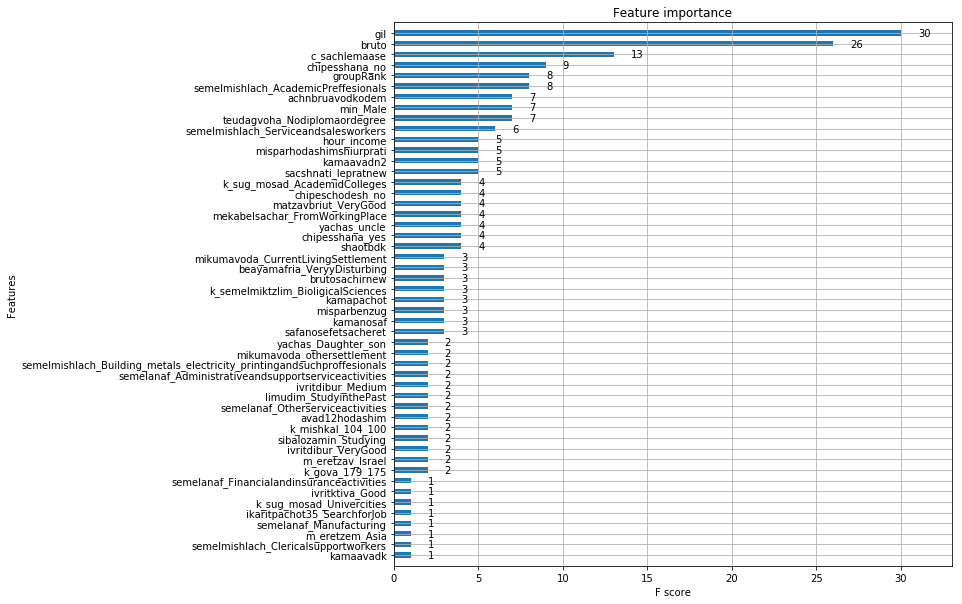

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]
plot_importance(bst, ax=None, height=0.5, xlim=None, ylim=None,
                title='Feature importance', xlabel='F score', ylabel='Features', 
                importance_type='weight', max_num_features=50 )


## SHAP Analysis of model results

In [15]:
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
shapv = pd.DataFrame(shap_values)
base_pred = explainer.expected_value


In [16]:
shapv.index = X_train.index
shapv.columns ='s_' + X_train.columns
shap_all = pd.concat([shapv,X_train],axis=1)

In [ ]:
a = shap_all.query('gil<22' ).sort_values(['gil']).index.sort_values()
b = shapv.loc[a,:].sum(axis=1).sort_values(ascending=True).index
shapv.loc[b,:]  

In [18]:
shap.force_plot(explainer.expected_value,shap_values[8,:], X_train.iloc[8,:])

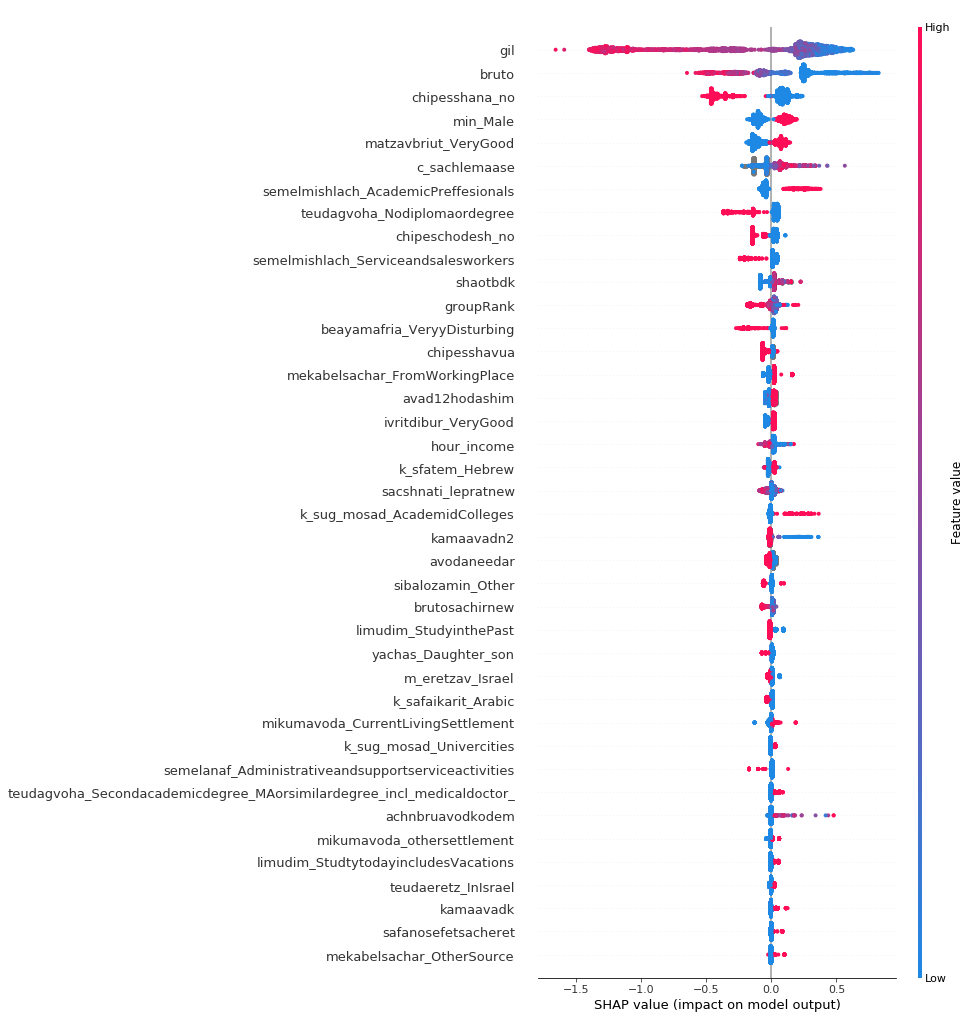

In [19]:
shap.summary_plot(shap_values, X_train ,max_display=40,plot_type = "dot")

In [20]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

In [21]:
shap_interaction_values.shape

(3168, 565, 565)

In [ ]:
shap.force_plot(explainer.expected_value,shap_values[1:100], X_train.iloc[1:100].fillna(0))

In [23]:
######
# function to prepare the leafs pathe conditions in one line for each leave of explantory tree
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]
     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     
     def recurse(left, right, child, lineage=None): 
          if lineage is None:
               lineage = [child] 
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'
          lineage.append((parent, split, threshold[parent], features[parent]))
          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)
     cond_list = []
     leaf_list = []
     for child in idx:
          path = list(recurse(left, right, child))
          condition = []          
          for node in range(len(path)-1):
            direction = '<=' if path[node][1] == 'l' else '>'   
            cond = path[node][3] + direction + str(path[node][2])
            condition.append(cond) 
          leaf_list.append(path[len(path)-1])  
          cond_list.append(' & '.join(condition))
     out = pd.DataFrame([leaf_list,cond_list]).T 
     out.columns = ['leaf','path']
     return out   
     

In [24]:
def var_report(data,model):
    # report for var level
    data['sum_effects'] = data['main_effect'] + data['base_pred']
    if model.get_params()['objective'] == 'reg:tweedie':
         data['pred'] = np.exp(data.sum_effects)
         data['pred_average'] =  np.exp(data['base_pred'])
    elif model.get_params()['objective'] == 'binary:logistic':
         data['pred'] = np.exp(data.sum_effects)/(1+np.exp(data.sum_effects))
         data['pred_average'] =  np.exp(data['base_pred'])/(1+np.exp(data['base_pred']))
    data['dif_pred'] = data['pred'] - data['pred_average']
    g = data.groupby(["path"])
    estimates = g.apply(lambda x: pd.Series({
          'n_pop'             : DescrStatsW(x.main_effect,weights=x.mishkalprat).nobs,
          'main_effect'       : DescrStatsW(x.main_effect,weights=x.mishkalprat).mean,
          'std_main_effect'   : DescrStatsW(x.main_effect,weights=x.mishkalprat).std,
          'base_pred'         : DescrStatsW(x.base_pred,weights=x.mishkalprat).mean,
          'sum_effects'       : DescrStatsW(x.sum_effects,weights=x.mishkalprat).mean,
          'pred_average'      : DescrStatsW(x.pred_average,weights=x.mishkalprat).mean,
          'pred_with_effect'  :  DescrStatsW(x.pred,weights=x.mishkalprat).mean,
          'dif_pred'          : DescrStatsW(x.dif_pred,weights=x.mishkalprat).mean,
          'actual'            : DescrStatsW(x[[y_train.name]],weights=x.mishkalprat).mean,
          'pred_xgboost'      : DescrStatsW(x.pred_xgboost,weights=x.mishkalprat).mean}))
    estimates['n'] = g['main_effect'].count()
    estimates['cv'] = estimates.main_effect/estimates.std_main_effect
    estimates = estimates.reset_index()
    rep1 = estimates[ ['path','main_effect','std_main_effect','cv']]
    rep2 = estimates[['path','n','n_pop','actual','pred_xgboost','pred_with_effect','dif_pred','pred_average']]
    print("shap analysis for var",col_name)
    display(rep1)
    print("shap prediction analysis for var",col_name)
    display(rep2.style.format({ 'n_pop': "{:,.0f}",'n':"{:,.0f}"}))


In [25]:
def var_interaction_report(data,model):       
     g = data.groupby(["path"])
     data['sum_effects_base'] = data['base_interaction'] + data['base_pred']
     data['sum_effects'] = data['sum_effects_base'] + data['interaction']  
     if model.get_params()['objective'] == 'reg:tweedie':
        data['pred'] = np.exp(data.sum_effects)
        data['pred_var']  = np.exp(data.sum_effects_base) 
        data['pred_average'] =  np.exp(data['base_pred'])
     elif model.get_params()['objective'] == 'binary:logistic': 
        data['pred'] = np.exp(data.sum_effects)/(1 +np.exp(data.sum_effects) )
        data['pred_var']  = np.exp(data.sum_effects_base)/(1 + np.exp(data.sum_effects_base) ) 
        data['pred_average'] =  np.exp(data['base_pred'])/(1 +np.exp(data['base_pred']) )
     data['dif_pred_base'] = data['pred_var'] - data['pred_average']
     data['dif_pred'] = data['pred'] - data['pred_var']
     
     estimates = g.apply(lambda x: pd.Series({
          'n_pop'                 :   DescrStatsW(x.interaction,weights=x.mishkalprat).nobs,
          'interaction_effect'    :   DescrStatsW(x.interaction,weights=x.mishkalprat).mean,
          'std_interaction_effect':   DescrStatsW(x.interaction,weights=x.mishkalprat).std,
          'pred_var'             :    DescrStatsW(x.pred_var,weights=x.mishkalprat).mean,
          'pred'                  :   DescrStatsW(x.pred,weights=x.mishkalprat).mean,
          'pred_average'          :   DescrStatsW(x.pred_average,weights=x.mishkalprat).mean,
          'dif_pred_base'         :   DescrStatsW(x.dif_pred_base,weights=x.mishkalprat).mean,
          'dif_pred'              :   DescrStatsW(x.dif_pred,weights=x.mishkalprat).mean,
          'actual'                :   DescrStatsW(x[[y_train.name]],weights=x.mishkalprat).mean,
          'pred_xgboost'          :   DescrStatsW(x.pred_xgboost,weights=x.mishkalprat).mean}))
     estimates['n'] = g['interaction'].count()
     estimates['cv'] = estimates.interaction_effect/estimates.std_interaction_effect
     estimates = estimates.reset_index()   
     rep1 = estimates[['path', 'interaction_effect','std_interaction_effect', 'cv']] 
                           
     rep2 = estimates[['path', 'n_pop','n','actual','pred_xgboost','pred_var','dif_pred_base','pred','dif_pred',
                           'pred_average']] 
     print("shap interaction analysis for var",col_name, "with var ", col_name2)
     display(rep1)
     print("shap pred interaction analysis for var",col_name, "with var ", col_name2)
     display(rep2.style.format({ 'n_pop': "{:,.0f}",'n': "{:,.0f}"}))

## Shap analysis for features
#### inputs requiered for the analysis:
####         shap_values 
####         shap_interaction_values

____________________________________________________________________________________________________
Analysis for variable:  gil
____________________________________________________________________________________________________
shap gross effect = shap main effect + sum of shap interaction effects for variable gil
____________________________________________________________________________________________________


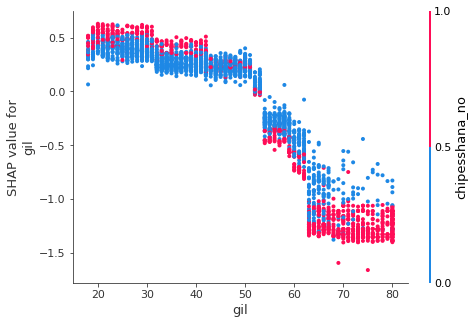

None

shap main effects = shap gross effect - sum of shap interaction effects for variable gil
____________________________________________________________________________________________________


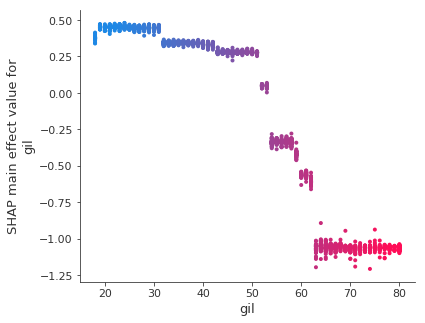

None

shap analysis for var gil


,path,main_effect,std_main_effect,cv
0,gil<=21.5 & gil<=19.5,0.420228,0.039093,10.749408
1,gil<=21.5 & gil>19.5,0.449178,0.011829,37.972404
2,gil>21.5 & gil<=44.5 & gil<=34.5,0.418971,0.047790,8.766937
3,gil>21.5 & gil<=44.5 & gil>34.5,0.328403,0.023290,14.100296
4,gil>21.5 & gil>44.5 & gil<=68.5,-0.321142,0.506736,-0.633745
5,gil>21.5 & gil>44.5 & gil>68.5,-1.068310,0.020786,-51.395724


shap prediction analysis for var gil


,path,n,n_pop,actual,pred_xgboost,pred_with_effect,dif_pred,pred_average
0,gil<=21.5 & gil<=19.5,81,"66,467",[0.42484264],0.440246,0.374254,0.0922277,0.282027
1,gil<=21.5 & gil>19.5,76,"59,985",[0.42694442],0.427039,0.381017,0.0989899,0.282027
2,gil>21.5 & gil<=44.5 & gil<=34.5,778,"445,919",[0.42473376],0.407762,0.373983,0.0919568,0.282027
3,gil>21.5 & gil<=44.5 & gil>34.5,570,"306,276",[0.36260604],0.35479,0.352984,0.0709575,0.282027
4,gil>21.5 & gil>44.5 & gil<=68.5,"1,195","584,908",[0.21851376],0.237591,0.233646,-0.0483808,0.282027
5,gil>21.5 & gil>44.5 & gil>68.5,468,"246,751",[0.03585768],0.0633835,0.118933,-0.163094,0.282027


shap main effect and interaction effects for  35 obsveration for variable gil
____________________________________________________________________________________________________


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  c_sachlemaase
____________________________________________________________________________________________________
sum interaction values:  137.37933


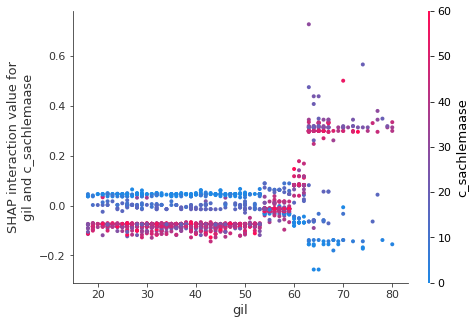

None

shap interaction analysis for var gil with var  c_sachlemaase


,path,interaction_effect,std_interaction_effect,cv
0,c_sachlemaase<=0.5 & gil<=21.5 & gil<=19.5,0.019371,0.006966,2.780675
1,c_sachlemaase<=0.5 & gil<=21.5 & gil>19.5,0.020115,0.005566,3.613655
2,c_sachlemaase<=0.5 & gil>21.5 & gil<=68.5,-0.003093,0.039544,-0.078211
3,c_sachlemaase<=0.5 & gil>21.5 & gil>68.5,-0.078560,0.007555,-10.398271
4,c_sachlemaase>0.5 & gil<=22.5,-0.029664,0.021469,-1.381739
5,c_sachlemaase>0.5 & gil>22.5 & gil<=34.5,-0.032251,0.018154,-1.776471
6,c_sachlemaase>0.5 & gil>22.5 & gil>34.5,-0.001720,0.064750,-0.026571


shap pred interaction analysis for var gil with var  c_sachlemaase


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,c_sachlemaase<=0.5 & gil<=21.5 & gil<=19.5,"42,067",51,[0.35100917],0.403477,0.374509,0.092482,0.379059,0.00455023,0.282027
1,c_sachlemaase<=0.5 & gil<=21.5 & gil>19.5,"36,705",51,[0.3668727],0.418841,0.380883,0.0988564,0.385637,0.0047544,0.282027
2,c_sachlemaase<=0.5 & gil>21.5 & gil<=68.5,"407,585","1,002",[0.24943655],0.256025,0.292102,0.0100755,0.293441,0.00133924,0.282027
3,c_sachlemaase<=0.5 & gil>21.5 & gil>68.5,"217,694",427,[0.00593212],0.0421871,0.119162,-0.162865,0.111158,-0.00800383,0.282027
4,c_sachlemaase>0.5 & gil<=22.5,"63,895",77,[0.53587191],0.463595,0.378458,0.0964313,0.371518,-0.00693993,0.282027
5,c_sachlemaase>0.5 & gil>22.5 & gil<=34.5,"295,999",463,[0.4374762],0.418101,0.373038,0.0910115,0.365544,-0.00749432,0.282027
6,c_sachlemaase>0.5 & gil>22.5 & gil>34.5,"646,361","1,097",[0.30329683],0.310535,0.277374,-0.00465308,0.27494,-0.00243329,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  chipesshana_no
____________________________________________________________________________________________________
sum interaction values:  121.81254


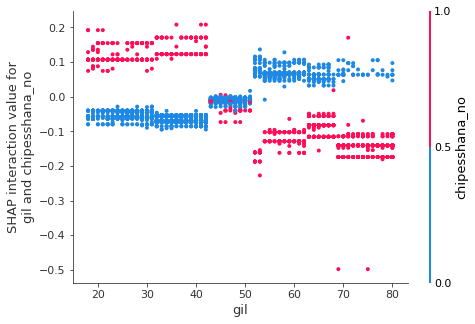

None

shap interaction analysis for var gil with var  chipesshana_no


,path,interaction_effect,std_interaction_effect,cv
0,gil<=21.5 & chipesshana_no<=0.5,-0.024805,0.005589,-4.437858
1,gil<=21.5 & chipesshana_no>0.5,0.058687,0.013417,4.374074
2,gil>21.5 & chipesshana_no<=0.5 & gil<=34.5,-0.028014,0.006064,-4.620105
3,gil>21.5 & chipesshana_no<=0.5 & gil>34.5,0.003179,0.029375,0.108217
4,gil>21.5 & chipesshana_no>0.5 & gil<=68.5,-0.001471,0.057535,-0.025572
5,gil>21.5 & chipesshana_no>0.5 & gil>68.5,-0.074225,0.016093,-4.612331


shap pred interaction analysis for var gil with var  chipesshana_no


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,gil<=21.5 & chipesshana_no<=0.5,"80,521",98,[0.47525462],0.464808,0.378086,0.0960594,0.372273,-0.00581261,0.282027
1,gil<=21.5 & chipesshana_no>0.5,"45,931",59,[0.33921079],0.379939,0.376368,0.0943416,0.390233,0.0138652,0.282027
2,gil>21.5 & chipesshana_no<=0.5 & gil<=34.5,"382,641",639,[0.44510711],0.422723,0.373919,0.091892,0.367396,-0.00652304,0.282027
3,gil>21.5 & chipesshana_no<=0.5 & gil>34.5,"752,186","1,362",[0.30628563],0.311818,0.278492,-0.00353449,0.278112,-0.000380239,0.282027
4,gil>21.5 & chipesshana_no>0.5 & gil<=68.5,"236,602",595,[0.15021335],0.170974,0.266282,-0.0157442,0.268383,0.00210046,0.282027
5,gil>21.5 & chipesshana_no>0.5 & gil>68.5,"212,424",415,[0.0041045],0.039315,0.11923,-0.162797,0.111649,-0.00758137,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  shaotbdk
____________________________________________________________________________________________________
sum interaction values:  93.0496


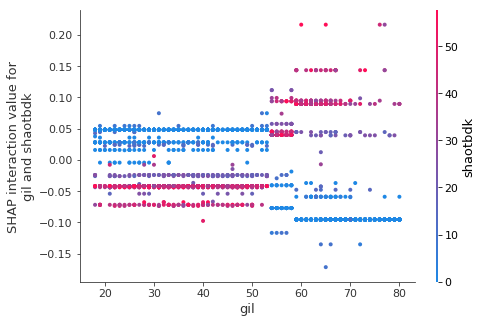

None

shap interaction analysis for var gil with var  shaotbdk


,path,interaction_effect,std_interaction_effect,cv
0,shaotbdk<=0.5 & gil<=21.5 & gil<=19.5,0.020268,0.005644,3.590806
1,shaotbdk<=0.5 & gil<=21.5 & gil>19.5,0.017997,0.011255,1.599003
2,shaotbdk<=0.5 & gil>21.5 & gil<=68.5,-0.002705,0.031452,-0.086002
3,shaotbdk<=0.5 & gil>21.5 & gil>68.5,-0.047104,0.006991,-6.737465
4,shaotbdk>0.5 & gil<=21.5,-0.015926,0.014744,-1.080186
5,shaotbdk>0.5 & gil>21.5 & gil<=34.5,-0.018190,0.012255,-1.484277
6,shaotbdk>0.5 & gil>21.5 & gil>34.5,-0.000158,0.030202,-0.005216


shap pred interaction analysis for var gil with var  shaotbdk


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,shaotbdk<=0.5 & gil<=21.5 & gil<=19.5,"42,067",51,[0.35100917],0.403477,0.374509,0.092482,0.379266,0.00475754,0.282027
1,shaotbdk<=0.5 & gil<=21.5 & gil>19.5,"36,269",50,[0.37127936],0.419574,0.380856,0.0988291,0.385109,0.00425343,0.282027
2,shaotbdk<=0.5 & gil>21.5 & gil<=68.5,"395,051",962,[0.24607125],0.253223,0.291194,0.00916731,0.291871,0.000676785,0.282027
3,shaotbdk<=0.5 & gil>21.5 & gil>68.5,"217,275",426,[0.00401288],0.0409994,0.119176,-0.16285,0.114321,-0.00485495,0.282027
4,shaotbdk>0.5 & gil<=21.5,"48,116",56,[0.53238801],0.47151,0.377486,0.0954595,0.373752,-0.00373378,0.282027
5,shaotbdk>0.5 & gil>21.5 & gil<=34.5,"315,983",496,[0.44179468],0.418982,0.373405,0.0913787,0.369167,-0.00423822,0.282027
6,shaotbdk>0.5 & gil>21.5 & gil>34.5,"655,544","1,127",[0.30422092],0.310834,0.277578,-0.00444887,0.276544,-0.00103339,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  teudagvoha_Nodiplomaordegree
____________________________________________________________________________________________________
sum interaction values:  71.58648


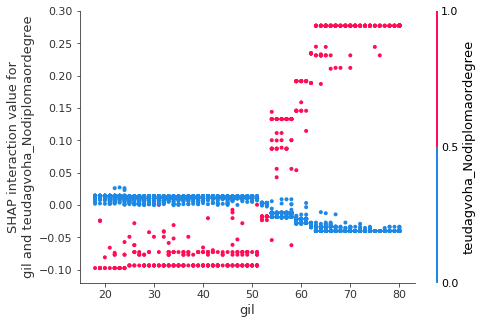

None

shap interaction analysis for var gil with var  teudagvoha_Nodiplomaordegree


,path,interaction_effect,std_interaction_effect,cv
0,gil<=21.5 & gil<=19.5,0.001488,0.014593,0.101940
1,gil<=21.5 & gil>19.5,0.002490,0.012657,0.196740
2,gil>21.5 & gil<=44.5 & gil<=34.5,0.000036,0.014813,0.002458
3,gil>21.5 & gil<=44.5 & gil>34.5,-0.000923,0.016276,-0.056699
4,gil>21.5 & gil>44.5 & gil<=68.5,0.005196,0.038387,0.135360
5,gil>21.5 & gil>44.5 & gil>68.5,0.034494,0.074923,0.460397


shap pred interaction analysis for var gil with var  teudagvoha_Nodiplomaordegree


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,gil<=21.5 & gil<=19.5,"66,467",81,[0.42484264],0.440246,0.374254,0.0922277,0.3746,0.000345535,0.282027
1,gil<=21.5 & gil>19.5,"59,985",76,[0.42694442],0.427039,0.381017,0.0989899,0.381607,0.000590942,0.282027
2,gil>21.5 & gil<=44.5 & gil<=34.5,"445,919",778,[0.42473376],0.407762,0.373983,0.0919568,0.373999,1.58077e-05,0.282027
3,gil>21.5 & gil<=44.5 & gil>34.5,"306,276",570,[0.36260604],0.35479,0.352984,0.0709575,0.352783,-0.000201121,0.282027
4,gil>21.5 & gil>44.5 & gil<=68.5,"584,908","1,195",[0.21851376],0.237591,0.233646,-0.0483808,0.234309,0.000663153,0.282027
5,gil>21.5 & gil>44.5 & gil>68.5,"246,751",468,[0.03585768],0.0633835,0.118933,-0.163094,0.122792,0.00385969,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  bruto
____________________________________________________________________________________________________
sum interaction values:  67.02345


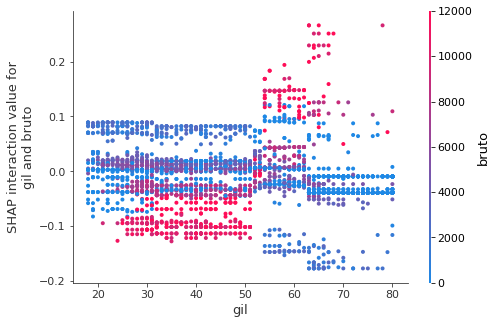

None

shap interaction analysis for var gil with var  bruto


,path,interaction_effect,std_interaction_effect,cv
0,bruto<=42.5 & gil<=21.5,-0.003952,0.012084,-0.327019
1,bruto<=42.5 & gil>21.5 & gil<=68.5,-0.002059,0.016947,-0.121494
2,bruto<=42.5 & gil>21.5 & gil>68.5,-0.012749,0.009839,-1.295845
3,bruto>42.5 & gil<=21.5,0.023011,0.019576,1.175489
4,bruto>42.5 & gil>21.5 & gil<=34.5,-0.001426,0.027753,-0.051366
5,bruto>42.5 & gil>21.5 & gil>34.5,-0.004221,0.040993,-0.102971


shap pred interaction analysis for var gil with var  bruto


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,bruto<=42.5 & gil<=21.5,"49,465",68,[0.42456756],0.406442,0.377084,0.0950572,0.376152,-0.00093174,0.282027
1,bruto<=42.5 & gil>21.5 & gil<=68.5,"359,002",844,[0.30206837],0.286574,0.282016,-1.06811e-05,0.281655,-0.000361316,0.282027
2,bruto<=42.5 & gil>21.5 & gil>68.5,"219,139",427,[0.01503528],0.0492537,0.119083,-0.162944,0.117748,-0.00133475,0.282027
3,bruto>42.5 & gil<=21.5,"76,987",89,[0.42665701],0.451676,0.377705,0.0956785,0.38313,0.00542506,0.282027
4,bruto>42.5 & gil>21.5 & gil<=34.5,"346,133",570,[0.41970285],0.407569,0.373612,0.0915852,0.373307,-0.000305207,0.282027
5,bruto>42.5 & gil>21.5 & gil>34.5,"659,580","1,170",[0.27305531],0.288599,0.279308,-0.00271905,0.278411,-0.000896488,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  min_Male
____________________________________________________________________________________________________
sum interaction values:  41.92433


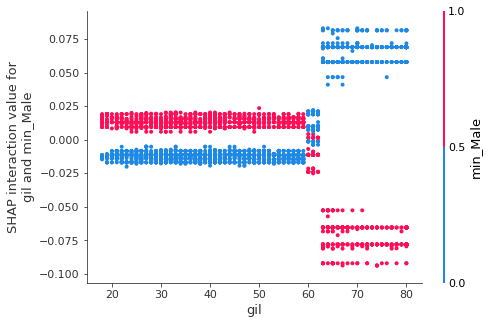

None

shap interaction analysis for var gil with var  min_Male


,path,interaction_effect,std_interaction_effect,cv
0,gil<=21.5 & min_Male<=0.5,-0.006124,0.001024,-5.981582
1,gil<=21.5 & min_Male>0.5,0.006621,0.001424,4.650467
2,gil>21.5 & gil<=44.5 & min_Male<=0.5,-0.006242,0.001494,-4.179162
3,gil>21.5 & gil<=44.5 & min_Male>0.5,0.006479,0.001677,3.863563
4,gil>21.5 & gil>44.5 & gil<=68.5,0.000241,0.017409,0.013860
5,gil>21.5 & gil>44.5 & gil>68.5,0.004501,0.034571,0.130202


shap pred interaction analysis for var gil with var  min_Male


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,gil<=21.5 & min_Male<=0.5,"51,569",70,[0.46306395],0.422127,0.378321,0.0962944,0.376882,-0.00143905,0.282027
1,gil<=21.5 & min_Male>0.5,"74,883",87,[0.4002046],0.442145,0.376871,0.0948439,0.378426,0.00155591,0.282027
2,gil>21.5 & gil<=44.5 & min_Male<=0.5,"397,843",743,[0.34813311],0.368732,0.364933,0.0829063,0.363489,-0.00144416,0.282027
3,gil>21.5 & gil<=44.5 & min_Male>0.5,"354,352",605,[0.45703743],0.405798,0.365994,0.0839678,0.367497,0.00150256,0.282027
4,gil>21.5 & gil>44.5 & gil<=68.5,"584,908","1,195",[0.21851376],0.237591,0.233646,-0.0483808,0.233643,-3.25034e-06,0.282027
5,gil>21.5 & gil>44.5 & gil>68.5,"246,751",468,[0.03585768],0.0633835,0.118933,-0.163094,0.119449,0.000516597,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  semelmishlach_AcademicPreffesionals
____________________________________________________________________________________________________
sum interaction values:  38.92078


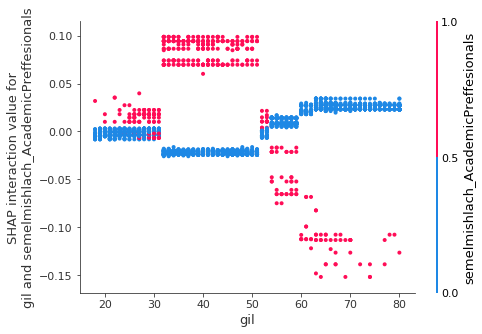

None

shap interaction analysis for var gil with var  semelmishlach_AcademicPreffesionals


,path,interaction_effect,std_interaction_effect,cv
0,gil<=21.5 & gil<=19.5,-0.001426,0.002189,-0.651478
1,gil<=21.5 & gil>19.5,-0.000420,0.003041,-0.138192
2,gil>21.5 & gil<=44.5 & gil<=34.5,0.001678,0.013527,0.124029
3,gil>21.5 & gil<=44.5 & gil>34.5,0.002798,0.023573,0.118687
4,gil>21.5 & gil>44.5 & gil<=68.5,0.001394,0.017960,0.077624
5,gil>21.5 & gil>44.5 & gil>68.5,0.009695,0.014820,0.654181


shap pred interaction analysis for var gil with var  semelmishlach_AcademicPreffesionals


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,gil<=21.5 & gil<=19.5,"66,467",81,[0.42484264],0.440246,0.374254,0.0922277,0.373921,-0.000333483,0.282027
1,gil<=21.5 & gil>19.5,"59,985",76,[0.42694442],0.427039,0.381017,0.0989899,0.380918,-9.87646e-05,0.282027
2,gil>21.5 & gil<=44.5 & gil<=34.5,"445,919",778,[0.42473376],0.407762,0.373983,0.0919568,0.374377,0.000393253,0.282027
3,gil>21.5 & gil<=44.5 & gil>34.5,"306,276",570,[0.36260604],0.35479,0.352984,0.0709575,0.353641,0.000656562,0.282027
4,gil>21.5 & gil>44.5 & gil<=68.5,"584,908","1,195",[0.21851376],0.237591,0.233646,-0.0483808,0.233763,0.000117207,0.282027
5,gil>21.5 & gil>44.5 & gil>68.5,"246,751",468,[0.03585768],0.0633835,0.118933,-0.163094,0.119964,0.00103146,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  m_eretzav_Israel
____________________________________________________________________________________________________
sum interaction values:  22.537073


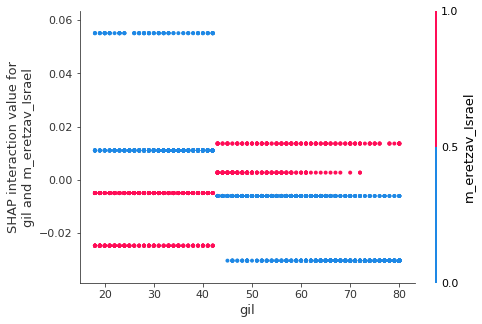

None

shap interaction analysis for var gil with var  m_eretzav_Israel


,path,interaction_effect,std_interaction_effect,cv
0,gil<=21.5 & gil<=19.5,-0.000379,0.010903,-0.034724
1,gil<=21.5 & gil>19.5,-0.000334,0.011632,-0.028687
2,gil>21.5 & gil<=44.5 & gil<=34.5,0.001172,0.007827,0.149711
3,gil>21.5 & gil<=44.5 & gil>34.5,0.002144,0.007177,0.298664
4,gil>21.5 & gil>44.5 & m_eretzav_Israel<=0.5,-0.008023,0.005974,-1.342982
5,gil>21.5 & gil>44.5 & m_eretzav_Israel>0.5,0.003886,0.002720,1.428326


shap pred interaction analysis for var gil with var  m_eretzav_Israel


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,gil<=21.5 & gil<=19.5,"66,467",81,[0.42484264],0.440246,0.374254,0.0922277,0.374167,-8.70823e-05,0.282027
1,gil<=21.5 & gil>19.5,"59,985",76,[0.42694442],0.427039,0.381017,0.0989899,0.380938,-7.82779e-05,0.282027
2,gil>21.5 & gil<=44.5 & gil<=34.5,"445,919",778,[0.42473376],0.407762,0.373983,0.0919568,0.374258,0.000274783,0.282027
3,gil>21.5 & gil<=44.5 & gil>34.5,"306,276",570,[0.36260604],0.35479,0.352984,0.0709575,0.353476,0.000492207,0.282027
4,gil>21.5 & gil>44.5 & m_eretzav_Israel<=0.5,"684,841","1,329",[0.1714567],0.18264,0.190298,-0.0917287,0.189277,-0.00102071,0.282027
5,gil>21.5 & gil>44.5 & m_eretzav_Israel>0.5,"146,817",334,[0.13103173],0.201131,0.243051,-0.0389752,0.243669,0.000617659,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  gil  with  avodaneedar
____________________________________________________________________________________________________
sum interaction values:  22.524973


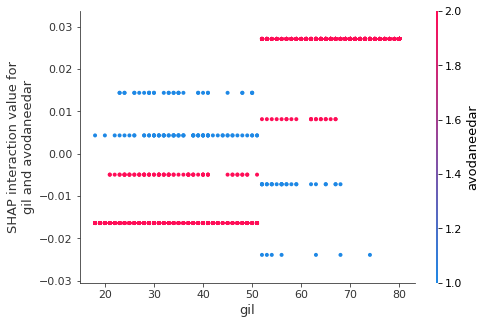

None

shap interaction analysis for var gil with var  avodaneedar


,path,interaction_effect,std_interaction_effect,cv
0,avodaneedar<=0.5 & gil<=21.5,0.005708,0.002300,2.482089
1,avodaneedar<=0.5 & gil>21.5 & gil<=34.5,0.003474,0.002204,1.575799
2,avodaneedar<=0.5 & gil>21.5 & gil>34.5,-0.000744,0.005585,-0.133221
3,avodaneedar>0.5 & gil<=21.5,-0.007803,0.001765,-4.421587
4,avodaneedar>0.5 & gil>21.5 & gil<=68.5,0.000965,0.009727,0.099213
5,avodaneedar>0.5 & gil>21.5 & gil>68.5,0.013495,0.001410,9.568142


shap pred interaction analysis for var gil with var  avodaneedar


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,avodaneedar<=0.5 & gil<=21.5,"80,367",87,[0.45176849],0.460738,0.377991,0.0959643,0.379333,0.00134211,0.282027
1,avodaneedar<=0.5 & gil>21.5 & gil<=34.5,"321,359",494,[0.45016707],0.423113,0.373749,0.0917229,0.374563,0.000813796,0.282027
2,avodaneedar<=0.5 & gil>21.5 & gil>34.5,"664,438","1,144",[0.31195887],0.313483,0.277886,-0.00414042,0.277939,5.31871e-05,0.282027
3,avodaneedar>0.5 & gil<=21.5,"46,085",70,[0.38062206],0.38732,0.37654,0.0945131,0.37471,-0.00182927,0.282027
4,avodaneedar>0.5 & gil>21.5 & gil<=68.5,"381,256",949,[0.22110715],0.241341,0.289311,0.00728483,0.289123,-0.000188944,0.282027
5,avodaneedar>0.5 & gil>21.5 & gil>68.5,"216,801",424,[0.00402165],0.0407146,0.119176,-0.162851,0.120599,0.00142392,0.282027


____________________________________________________________________________________________________
Analysis for variable:  bruto
____________________________________________________________________________________________________
shap gross effect = shap main effect + sum of shap interaction effects for variable bruto
____________________________________________________________________________________________________


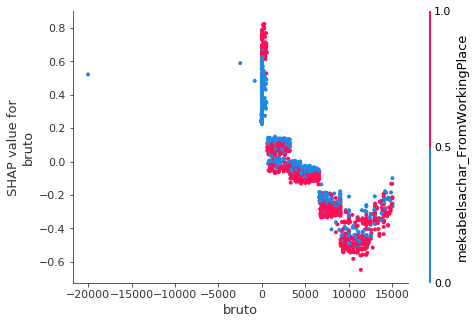

None

shap main effects = shap gross effect - sum of shap interaction effects for variable bruto
____________________________________________________________________________________________________


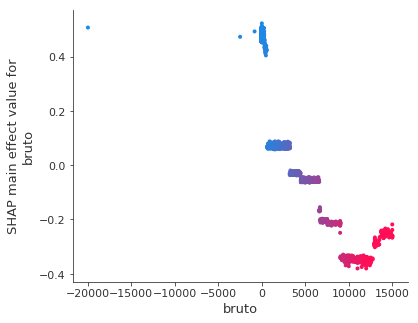

None

shap analysis for var bruto


,path,main_effect,std_main_effect,cv
0,bruto<=42.5,0.480425,0.013437,35.752997
1,bruto>42.5 & bruto<=471.17140197753906,0.452828,0.029177,15.519949
2,bruto>42.5 & bruto>471.17140197753906 & bruto<...,-0.079062,0.130434,-0.606142
3,bruto>42.5 & bruto>471.17140197753906 & bruto>...,-0.319219,0.042371,-7.533976


shap prediction analysis for var bruto


,path,n,n_pop,actual,pred_xgboost,pred_with_effect,dif_pred,pred_average
0,bruto<=42.5,"1,339","627,606",[0.21150112],0.213157,0.388413,0.106387,0.282027
1,bruto>42.5 & bruto<=471.17140197753906,62,"40,201",[0.77449343],0.605703,0.381897,0.0998706,0.282027
2,bruto>42.5 & bruto>471.17140197753906 & bruto<=10067.28125,"1,489","884,111",[0.32866835],0.338887,0.267072,-0.0149546,0.282027
3,bruto>42.5 & bruto>471.17140197753906 & bruto>10067.28125,278,"158,387",[0.23049161],0.266666,0.222155,-0.0598716,0.282027


shap main effect and interaction effects for  35 obsveration for variable bruto
____________________________________________________________________________________________________


____________________________________________________________________________________________________
Analysis for interaction of main column  bruto  with  chipesshana_no
____________________________________________________________________________________________________
sum interaction values:  168.6108


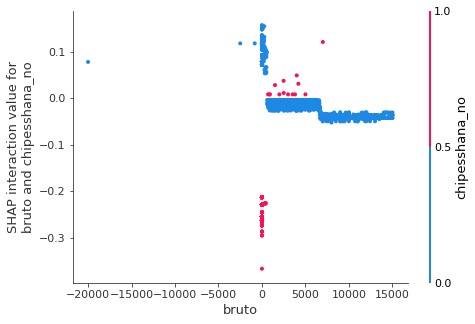

None

shap interaction analysis for var bruto with var  chipesshana_no


,path,interaction_effect,std_interaction_effect,cv
0,bruto<=42.5 & chipesshana_no<=0.5,0.047894,0.011466,4.176930
1,bruto<=42.5 & chipesshana_no>0.5,-0.122847,0.008921,-13.770567
2,bruto>42.5 & bruto<=471.17140197753906,0.020340,0.062765,0.324062
3,bruto>42.5 & bruto>471.17140197753906 & bruto<...,-0.010103,0.008565,-1.179555
4,bruto>42.5 & bruto>471.17140197753906 & bruto>...,-0.020166,0.001811,-11.132868


shap pred interaction analysis for var bruto with var  chipesshana_no


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,bruto<=42.5 & chipesshana_no<=0.5,"146,126",292,[0.57785824],0.498427,0.390709,0.108682,0.402166,0.0114574,0.282027
1,bruto<=42.5 & chipesshana_no>0.5,"481,480","1,047",[0.10031376],0.126579,0.387717,0.10569,0.358983,-0.0287334,0.282027
2,bruto>42.5 & bruto<=471.17140197753906,"40,201",62,[0.77449343],0.605703,0.381897,0.0998706,0.386871,0.00497338,0.282027
3,bruto>42.5 & bruto>471.17140197753906 & bruto<=10067.28125,"884,111","1,489",[0.32866835],0.338887,0.267072,-0.0149546,0.265188,-0.0018836,0.282027
4,bruto>42.5 & bruto>471.17140197753906 & bruto>10067.28125,"158,387",278,[0.23049161],0.266666,0.222155,-0.0598716,0.218692,-0.00346294,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  bruto  with  mekabelsachar_FromWorkingPlace
____________________________________________________________________________________________________
sum interaction values:  73.37472


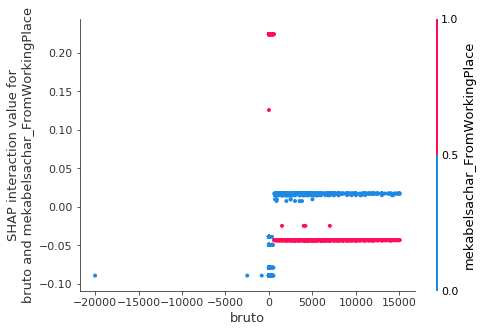

None

shap interaction analysis for var bruto with var  mekabelsachar_FromWorkingPlace


,path,interaction_effect,std_interaction_effect,cv
0,bruto<=42.5 & mekabelsachar_FromWorkingPlace<=0.5,-0.024433,0.009662,-2.528843
1,bruto<=42.5 & mekabelsachar_FromWorkingPlace>0.5,0.111559,0.004665,23.913009
2,bruto>42.5 & mekabelsachar_FromWorkingPlace<=0...,0.000229,0.017641,0.012987
3,bruto>42.5 & mekabelsachar_FromWorkingPlace<=0...,0.008505,0.000430,19.786668
4,bruto>42.5 & mekabelsachar_FromWorkingPlace>0....,-0.016434,0.025789,-0.637274
5,bruto>42.5 & mekabelsachar_FromWorkingPlace>0....,-0.021631,0.000000,NaN


shap pred interaction analysis for var bruto with var  mekabelsachar_FromWorkingPlace


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,bruto<=42.5 & mekabelsachar_FromWorkingPlace<=0.5,"599,335","1,283",[0.18071071],0.192081,0.388365,0.106338,0.382577,-0.00578756,0.282027
1,bruto<=42.5 & mekabelsachar_FromWorkingPlace>0.5,"28,272",56,[0.86422756],0.659958,0.389439,0.107412,0.416267,0.026828,0.282027
2,bruto>42.5 & mekabelsachar_FromWorkingPlace<=0.5 & bruto<=3025.0,"113,117",184,[0.40820872],0.398615,0.311016,0.0289893,0.310892,-0.000123511,0.282027
3,bruto>42.5 & mekabelsachar_FromWorkingPlace<=0.5 & bruto>3025.0,"211,911",392,[0.29603949],0.317693,0.250715,-0.0313116,0.252311,0.00159601,0.282027
4,bruto>42.5 & mekabelsachar_FromWorkingPlace>0.5 & bruto<=10067.28125,"643,978","1,053",[0.34907267],0.347425,0.268844,-0.0131828,0.265873,-0.00297126,0.282027
5,bruto>42.5 & mekabelsachar_FromWorkingPlace>0.5 & bruto>10067.28125,"113,693",200,[0.21564213],0.264339,0.221829,-0.0601975,0.218119,-0.00371036,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  bruto  with  shaotbdk
____________________________________________________________________________________________________
sum interaction values:  39.063637


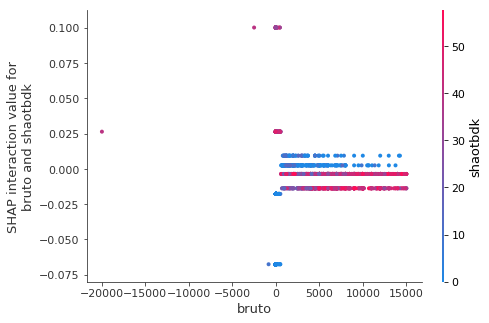

None

shap interaction analysis for var bruto with var  shaotbdk


,path,interaction_effect,std_interaction_effect,cv
0,shaotbdk<=0.5 & bruto<=6999.375 & bruto<=354.0,-0.022919,0.013811,-1.659488
1,shaotbdk<=0.5 & bruto<=6999.375 & bruto>354.0,-0.000453,0.003925,-0.115407
2,shaotbdk<=0.5 & bruto>6999.375,-0.000240,0.002898,-0.082739
3,shaotbdk>0.5 & bruto<=28.583332777023315 & sha...,0.016664,0.025050,0.665234
4,shaotbdk>0.5 & bruto<=28.583332777023315 & sha...,0.026823,0.017810,1.506102
5,shaotbdk>0.5 & bruto>28.583332777023315 & shao...,-0.002262,0.004714,-0.479908
6,shaotbdk>0.5 & bruto>28.583332777023315 & shao...,-0.002862,0.002299,-1.244992


shap pred interaction analysis for var bruto with var  shaotbdk


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,shaotbdk<=0.5 & bruto<=6999.375 & bruto<=354.0,"559,572","1,218",[0.15595137],0.168763,0.388116,0.10609,0.382688,-0.00542829,0.282027
1,shaotbdk<=0.5 & bruto<=6999.375 & bruto>354.0,"109,675",217,[0.30938231],0.372641,0.290767,0.00874081,0.290653,-0.000114272,0.282027
2,shaotbdk<=0.5 & bruto>6999.375,"21,414",54,[0.23894272],0.272273,0.230343,-0.051684,0.230303,-3.92483e-05,0.282027
3,shaotbdk>0.5 & bruto<=28.583332777023315 & shaotbdk<=44.0,"42,292",73,[0.63754444],0.549308,0.389902,0.107876,0.39388,0.00397781,0.282027
4,shaotbdk>0.5 & bruto<=28.583332777023315 & shaotbdk>44.0,"32,518",65,[0.66888957],0.579374,0.390502,0.108475,0.3969,0.00639834,0.282027
5,shaotbdk>0.5 & bruto>28.583332777023315 & shaotbdk<=54.5,"822,329","1,353",[0.3357261],0.336413,0.263781,-0.0182456,0.263368,-0.000413384,0.282027
6,shaotbdk>0.5 & bruto>28.583332777023315 & shaotbdk>54.5,"122,505",188,[0.32533637],0.327582,0.247555,-0.0344719,0.24703,-0.000525114,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  bruto  with  avodaneedar
____________________________________________________________________________________________________
sum interaction values:  27.019089


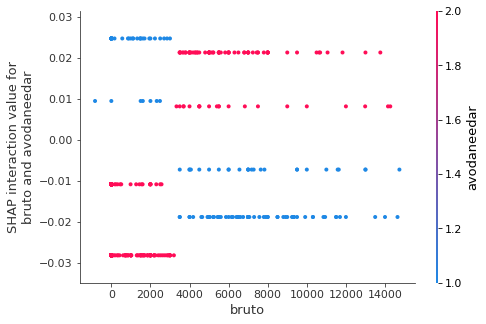

None

shap interaction analysis for var bruto with var  avodaneedar


,path,interaction_effect,std_interaction_effect,cv
0,avodaneedar<=0.5 & bruto<=72.28541564941406,0.009926,0.003547,2.798496
1,avodaneedar<=0.5 & bruto>72.28541564941406 & b...,0.011067,0.002853,3.878381
2,avodaneedar<=0.5 & bruto>72.28541564941406 & b...,-0.004761,0.007301,-0.652211
3,avodaneedar>0.5 & bruto<=3100.0 & bruto<=1195....,-0.008193,0.004822,-1.699183
4,avodaneedar>0.5 & bruto<=3100.0 & bruto>1195.9...,-0.007457,0.009981,-0.747115
5,avodaneedar>0.5 & bruto>3100.0 & bruto<=6999.375,0.002322,0.008947,0.259512
6,avodaneedar>0.5 & bruto>3100.0 & bruto>6999.375,-0.000403,0.008591,-0.046866


shap pred interaction analysis for var bruto with var  avodaneedar


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,avodaneedar<=0.5 & bruto<=72.28541564941406,"104,797",183,[0.61626875],0.539009,0.389477,0.10745,0.391841,0.00236427,0.282027
1,avodaneedar<=0.5 & bruto>72.28541564941406 & bruto<=924.3333435058594,"57,921",82,[0.64008246],0.541158,0.353005,0.070978,0.355528,0.00252294,0.282027
2,avodaneedar<=0.5 & bruto>72.28541564941406 & bruto>924.3333435058594,"903,446","1,460",[0.31722143],0.324822,0.257618,-0.024409,0.256768,-0.000849563,0.282027
3,avodaneedar>0.5 & bruto<=3100.0 & bruto<=1195.9326171875,"537,752","1,193",[0.13832773],0.155458,0.386638,0.104612,0.384701,-0.00193745,0.282027
4,avodaneedar>0.5 & bruto<=3100.0 & bruto>1195.9326171875,"35,941",69,[0.32856496],0.360369,0.295927,0.0139002,0.294379,-0.00154786,0.282027
5,avodaneedar>0.5 & bruto>3100.0 & bruto<=6999.375,"41,309",100,[0.27185759],0.334575,0.269092,-0.0129344,0.269566,0.000473692,0.282027
6,avodaneedar>0.5 & bruto>3100.0 & bruto>6999.375,"29,141",81,[0.18140596],0.285461,0.231912,-0.0501143,0.231851,-6.1646e-05,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  bruto  with  semelmishlach_Serviceandsalesworkers
____________________________________________________________________________________________________
sum interaction values:  22.171148


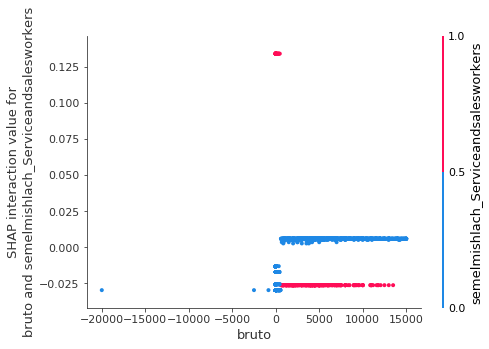

None

shap interaction analysis for var bruto with var  semelmishlach_Serviceandsalesworkers


,path,interaction_effect,std_interaction_effect,cv
0,bruto<=42.5,-0.006910,1.100154e-02,-6.281325e-01
1,bruto>42.5 & bruto<=471.17140197753906,-0.003901,2.614505e-02,-1.492229e-01
2,bruto>42.5 & bruto>471.17140197753906 & semelm...,0.002796,1.340459e-03,2.085935e+00
3,bruto>42.5 & bruto>471.17140197753906 & semelm...,-0.013169,3.344662e-09,-3.937394e+06


shap pred interaction analysis for var bruto with var  semelmishlach_Serviceandsalesworkers


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,bruto<=42.5,"627,606","1,339",[0.21150112],0.213157,0.388413,0.106387,0.386776,-0.00163766,0.282027
1,bruto>42.5 & bruto<=471.17140197753906,"40,201",62,[0.77449343],0.605703,0.381897,0.0998706,0.380998,-0.000899159,0.282027
2,bruto>42.5 & bruto>471.17140197753906 & semelmishlach_Serviceandsalesworkers<=0.5,"849,312","1,452",[0.34201477],0.341387,0.257158,-0.024869,0.257685,0.000527462,0.282027
3,bruto>42.5 & bruto>471.17140197753906 & semelmishlach_Serviceandsalesworkers>0.5,"193,187",315,[0.18950164],0.268685,0.273833,-0.00819374,0.271229,-0.00260404,0.282027


____________________________________________________________________________________________________
Analysis for interaction of main column  bruto  with  chipesshavua
____________________________________________________________________________________________________
sum interaction values:  21.834179


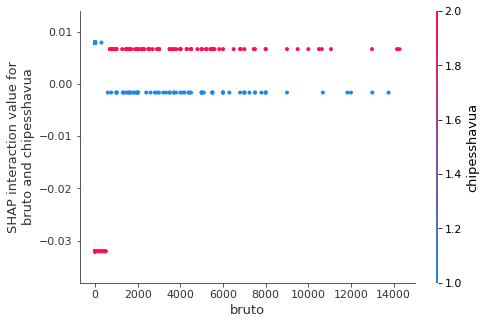

None

shap interaction analysis for var bruto with var  chipesshavua


,path,interaction_effect,std_interaction_effect,cv
0,chipesshavua<=0.5 & bruto<=72.28541564941406,0.005191,1.718799e-03,3.020226e+00
1,chipesshavua<=0.5 & bruto>72.28541564941406 & ...,0.003865,4.187331e-03,9.229591e-01
2,chipesshavua<=0.5 & bruto>72.28541564941406 & ...,-0.001519,3.874727e-04,-3.919753e+00
3,chipesshavua>0.5 & chipesshavua<=1.5 & bruto<=...,0.002972,1.940327e-03,1.531674e+00
4,chipesshavua>0.5 & chipesshavua<=1.5 & bruto>1...,-0.000826,0.000000e+00,NaN
5,chipesshavua>0.5 & chipesshavua>1.5 & bruto<=2...,-0.015440,3.303672e-03,-4.673700e+00
6,chipesshavua>0.5 & chipesshavua>1.5 & bruto>22...,0.003337,1.193575e-10,2.796061e+07


shap pred interaction analysis for var bruto with var  chipesshavua


,path,n_pop,n,actual,pred_xgboost,pred_var,dif_pred_base,pred,dif_pred,pred_average
0,chipesshavua<=0.5 & bruto<=72.28541564941406,"113,012",200,[0.61959022],0.537695,0.389545,0.107519,0.390781,0.00123514,0.282027
1,chipesshavua<=0.5 & bruto>72.28541564941406 & bruto<=924.3333435058594,"59,343",86,[0.63654284],0.541093,0.352639,0.0706127,0.353565,0.000925594,0.282027
2,chipesshavua<=0.5 & bruto>72.28541564941406 & bruto>924.3333435058594,"946,185","1,572",[0.31378308],0.32465,0.257633,-0.0243932,0.257344,-0.000289772,0.282027
3,chipesshavua>0.5 & chipesshavua<=1.5 & bruto<=1914.8194580078125,"47,100",87,[0.39853064],0.386826,0.371054,0.0890275,0.371767,0.000712887,0.282027
4,chipesshavua>0.5 & chipesshavua<=1.5 & bruto>1914.8194580078125,"25,560",54,[0.36098231],0.365791,0.265928,-0.0160989,0.265767,-0.000160727,0.282027
5,chipesshavua>0.5 & chipesshavua>1.5 & bruto<=2227.0,"497,515","1,113",[0.10409652],0.132795,0.385184,0.103158,0.381522,-0.00366228,0.282027
6,chipesshavua>0.5 & chipesshavua>1.5 & bruto>2227.0,"21,591",56,[0.30021985],0.291194,0.268807,-0.0132201,0.269461,0.000654583,0.282027


In [27]:
######
#  prepering parameters and main effeFcts data
# n = number of variables to analyse
# interaction_percentile = percentile for number of sugnificant interacting variables with main effect, to analyze
# n_to_split - minimum number to split trees
# n_for_force - number of obs for force plot
######

n=2 
interaction_percentile = 0.9
n_to_split=50
n_for_force = 35
shap_values = shap_values
shap_interaction_values = shap_interaction_values

tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))
treshold = np.quantile(tmp[np.nonzero(tmp)],interaction_percentile)
history = []
######
#  loop over  main effects ordered by strengrh, and do the analysis   
#####
for ind in inds[0:n]:
    ######
    #  analysis of  the main effect without interactions
    #####
    s = shap_interaction_values[:, ind, :]
    shap_main_effect  = pd.Series(s[:,ind],name="main_effect")
    shap_main_effect.index = X_train.index
    col_name = X_train.columns[ind]
    print("_"*100)
    print("Analysis for variable: ", col_name)
    print("_"*100)
    print("shap gross effect = shap main effect + sum of shap interaction effects for variable" ,col_name)
    print("_"*100)
    display(shap.dependence_plot((ind),shap_values, X_train))               
    print("shap main effects = shap gross effect - sum of shap interaction effects for variable" ,col_name)
    print("_"*100)
    display(shap.dependence_plot(
      (ind, ind),
      shap_interaction_values, X_train)) 
    
    ######
    #  prepare dataframe for cart analysis of main effect
    #####
    aa = pd.Series(s[:,ind])
    aa.index = X_train.index
    dat = X_train.iloc[:,[ind]]
    dat = pd.concat([dat,X_train_weight],axis=1,join='inner') 
    dat['base_pred'] = base_pred
    
    data = pd.concat([dat,aa],axis=1).fillna(0)
    data = data.rename({0: "interaction"}, axis='columns')            
    X = data.iloc[:,[0]] 
    y = data.iloc[:,[1]]
    ######
    #  running decision tree for  main effect - dependent variable: shap values, independent - only the variable itself 
    #####
    clf = tree.DecisionTreeRegressor(max_depth=3,min_samples_leaf=n_to_split)
    clf = clf.fit(X, y)
    ######
    #  extracting leafs data and if more the one leaf print pretty tble of average and std shap values in each leaf 
    #####
    leaf = clf.apply(X)
    leaf = pd.DataFrame(leaf,columns=['leaf'])
    if (leaf.nunique() > 1).bool():  
        condition = get_lineage(clf, data.columns.tolist())
        condition["leaf"] = pd.to_numeric(condition["leaf"])  
        tmp3 = pd.merge(leaf,condition,on='leaf',how='left') 
        tmp3.index = data.index
        
        if bst.get_params()['objective'] == 'reg:tweedie': predxg = pd.Series(pred_xgboost)
        elif bst.get_params()['objective'] == 'binary:logistic': predxg = pd.Series(pred_xgboost)
            
        predxg.index = data.index
        data = pd.concat([data,tmp3,shap_main_effect,y_train,predxg],axis=1)
        data = data.rename({0: "pred_xgboost"}, axis='columns') 
 
        var_report(data,bst)
 
        print("shap main effect and interaction effects for ", n_for_force ,"obsveration for variable",col_name)
        print("_"*100)
        display(shap.force_plot(explainer.expected_value,s[1:n_for_force,], X_train.iloc[1:n_for_force].fillna(0)))
        ######
        #  prepare data for analysis of the main effect ind with its interacting columns   
        #####
        indtmp = np.abs(s).sum(0)
        inds2 = np.argsort(-indtmp)
        
        for ind2 in inds2:
        ######
        #  analysis of main variables interactions with ind2 after checking strength and other conditions   
        ##### 
          if (indtmp[ind2] > treshold) & (ind2 != ind)  & ((ind,ind2)  not in history) & ((ind2,ind) not in history):
              ######
              #  interaction plot  
              #####  
              col_name2 = X_train.columns[ind2]
              print("_"*100)
              print("Analysis for interaction of main column ", col_name," with ", col_name2)
              print("_"*100)  
              print("sum interaction values: ",indtmp[ind2])
              display(shap.dependence_plot(
                (ind, ind2),
                shap_interaction_values, X_train))
              ######
              #  decision tree for finding signifacnt interaction combinations of main effect and its interaction variable 
              #####  
              aa = pd.Series(s[:,ind2])
              aa.index = X.index
              bb = pd.Series(s[:,ind])
              bb.index = X.index 
                
              dat = X_train.iloc[:,[ind,ind2]]
              dat = pd.concat([dat,X_train_weight],axis=1,join='inner')
              dat['base_pred'] = base_pred  
              data = pd.concat([dat,aa,bb],axis=1).fillna(0)
              data = data.rename({0: "interaction",1:'base_interaction'}, axis='columns')

              X = data.iloc[:,[0,1]] 
              y = data.iloc[:,2]
              clf = tree.DecisionTreeRegressor(max_depth=3,min_samples_leaf=n_to_split)
              clf = clf.fit(X, y)
              leaf = clf.apply(X)
              leaf = pd.DataFrame(leaf,columns=['leaf']) 
              ######
              #  preparing report of the interactions 
              ##### 
              condition = get_lineage(clf, data.columns.tolist())
              condition["leaf"] = pd.to_numeric(condition["leaf"])
              tmp3 = pd.merge(leaf,condition,on='leaf',how='left') 
              tmp3.index = data.index
                
              if bst.get_params()['objective'] == 'reg:tweedie': predxg = pd.Series(pred_xgboost)
              elif bst.get_params()['objective'] == 'binary:logistic': predxg = pd.Series(pred_xgboost)  
              predxg.index = data.index
                
              data = pd.concat([data,tmp3,shap_main_effect,y_train,predxg],axis=1)
              data = data.rename({0: "pred_xgboost"}, axis='columns')  
              var_interaction_report(data,bst)
              
              history.append((ind,ind2))